### Generate Insight into the correlation between Error- and UQ Maps of the reconstruction (R1 vs R3 or R6)


In [99]:
import sqlite3
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

REGIONS     = ["slice", "prostate", "lesion"]
ACC_LEVELS  = [3, 6]
METHOD_MAP  = {"gaussian": "GN-MC", "lxo": "ET-Drop"}

# === Configurable Parameters ===
DB_FPATH  = Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db')
TABLE     = "uq_vs_error_correlation_std"  # or remove _debug if running final
FIGDIR    = Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/figures')
VERBOSE   = True


# === SQLite DB Utilities ===

def connect_db(db_path: Path) -> sqlite3.Connection:
    """Establish and return SQLite connection."""
    return sqlite3.connect(str(db_path))

def run_query(conn: sqlite3.Connection, query: str) -> pd.DataFrame:
    """Execute a SQL query and return the result as a DataFrame."""
    return pd.read_sql_query(query, conn)

def preview_table(conn: sqlite3.Connection, table_name: str, n: int = 5):
    """Print the first n rows of the specified table."""
    df = run_query(conn, f"SELECT * FROM {table_name} LIMIT {n};")
    display(df)

# === Establish Connection ===
conn = connect_db(DB_FPATH)

# === Preview Table (Optional) ===
if VERBOSE:
    print(f"🔍 Preview of '{TABLE}' table:")
    preview_table(conn, TABLE)

🔍 Preview of 'uq_vs_error_correlation_std' table:


,pat_id,slice_idx,acc_factor,uq_method,region,mean_abs,mean_uq,std_uq,pearson_corr,spearman_corr
0,0003_ANON5046358,0,3,gaussian,slice,8.835545,0.000991,0.000257,0.367489,0.374207
1,0003_ANON5046358,1,3,gaussian,slice,9.663578,0.001003,0.000257,0.413001,0.388464
2,0003_ANON5046358,2,3,gaussian,slice,8.432629,0.001011,0.000259,0.392491,0.368357
3,0003_ANON5046358,3,3,gaussian,slice,8.865566,0.001011,0.000253,0.339506,0.329187
4,0003_ANON5046358,4,3,gaussian,slice,9.475834,0.001019,0.000259,0.414462,0.417164


In [108]:
# --- Pull all slice-level correlations including region ---
query = f"""
SELECT pat_id, uq_method, acc_factor, region, spearman_corr
FROM {TABLE}
WHERE spearman_corr IS NOT NULL;
"""
correlation_data = run_query(conn, query)

correlation_data.head()

new_col_names = {
    "pat_id": "Patient ID",
    "uq_method": "UQ Method",
    "acc_factor": "R",
    "region": "Region",
    "spearman_corr": "Correlation"
}
correlation_data.rename(columns=new_col_names, inplace=True)

correlation_data.head()


,Patient ID,UQ Method,R,Region,Correlation
0,0003_ANON5046358,gaussian,3,slice,0.374207
1,0003_ANON5046358,gaussian,3,slice,0.388464
2,0003_ANON5046358,gaussian,3,slice,0.368357
3,0003_ANON5046358,gaussian,3,slice,0.329187
4,0003_ANON5046358,gaussian,3,slice,0.417164


# Wilcox test

In [114]:

df = correlation_data.copy()

# --- 1. Harmonise labels (overwrite) ---------------------------------------
df["UQ Method"] = df["UQ Method"].replace(METHOD_MAP)
df = df[df.R.isin(ACC_LEVELS)]

# --- 2. Patient-level median ----------------------------------------------
df_pat = (df.groupby(["Patient ID", "R", "UQ Method", "Region"], as_index=False)
            .Correlation.median())

# --- 3. Paired Wilcoxon ----------------------------------------------------
rows = []
for R in ACC_LEVELS:
    for reg in REGIONS:
        sub  = df_pat.query("R == @R and Region == @reg")
        wide = sub.pivot(index="Patient ID",
                         columns="UQ Method",
                         values="Correlation").dropna()

        if {"GN-MC", "ET-Drop"}.issubset(wide.columns):
            stat, p = wilcoxon(wide["GN-MC"], wide["ET-Drop"])
            rows.append({"R": R, "region": reg, "n": len(wide),
                         "W": stat, "p_value": p})
        else:
            rows.append({"R": R, "region": reg, "n": len(wide),
                         "W": None, "p_value": None})

wilcox_table = pd.DataFrame(rows)

# add significance stars
def add_sig_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.010:
        return '**'
    elif p < 0.050:
        return '*'
    else:
        return 'ns'

wilcox_table = wilcox_table.copy()
wilcox_table["sig"] = wilcox_table.p_value.apply(add_sig_star)

print(wilcox_table)


   R    region    n       W       p_value  sig
0  3     slice  119  1169.0  1.927634e-10  ***
1  3  prostate  118  2639.0  1.926469e-02    *
2  3    lesion   36   291.0  5.189233e-01   ns
3  6     slice  119  1026.0  1.517599e-11  ***
4  6  prostate  119   777.0  1.296683e-13  ***
5  6    lesion   36   238.0  1.389850e-01   ns


# Visualises difference between UQ methods for each (R, region) and prints basic symmetry stats.

R=3, Region=slice:  mean=-0.037, median=-0.036, n=119
R=3, Region=prostate:  mean=-0.009, median=-0.009, n=118
R=3, Region=lesion:  mean=-0.029, median=0.003, n=36
R=6, Region=slice:  mean=0.042, median=0.045, n=119
R=6, Region=prostate:  mean=0.045, median=0.042, n=119
R=6, Region=lesion:  mean=0.020, median=0.068, n=36


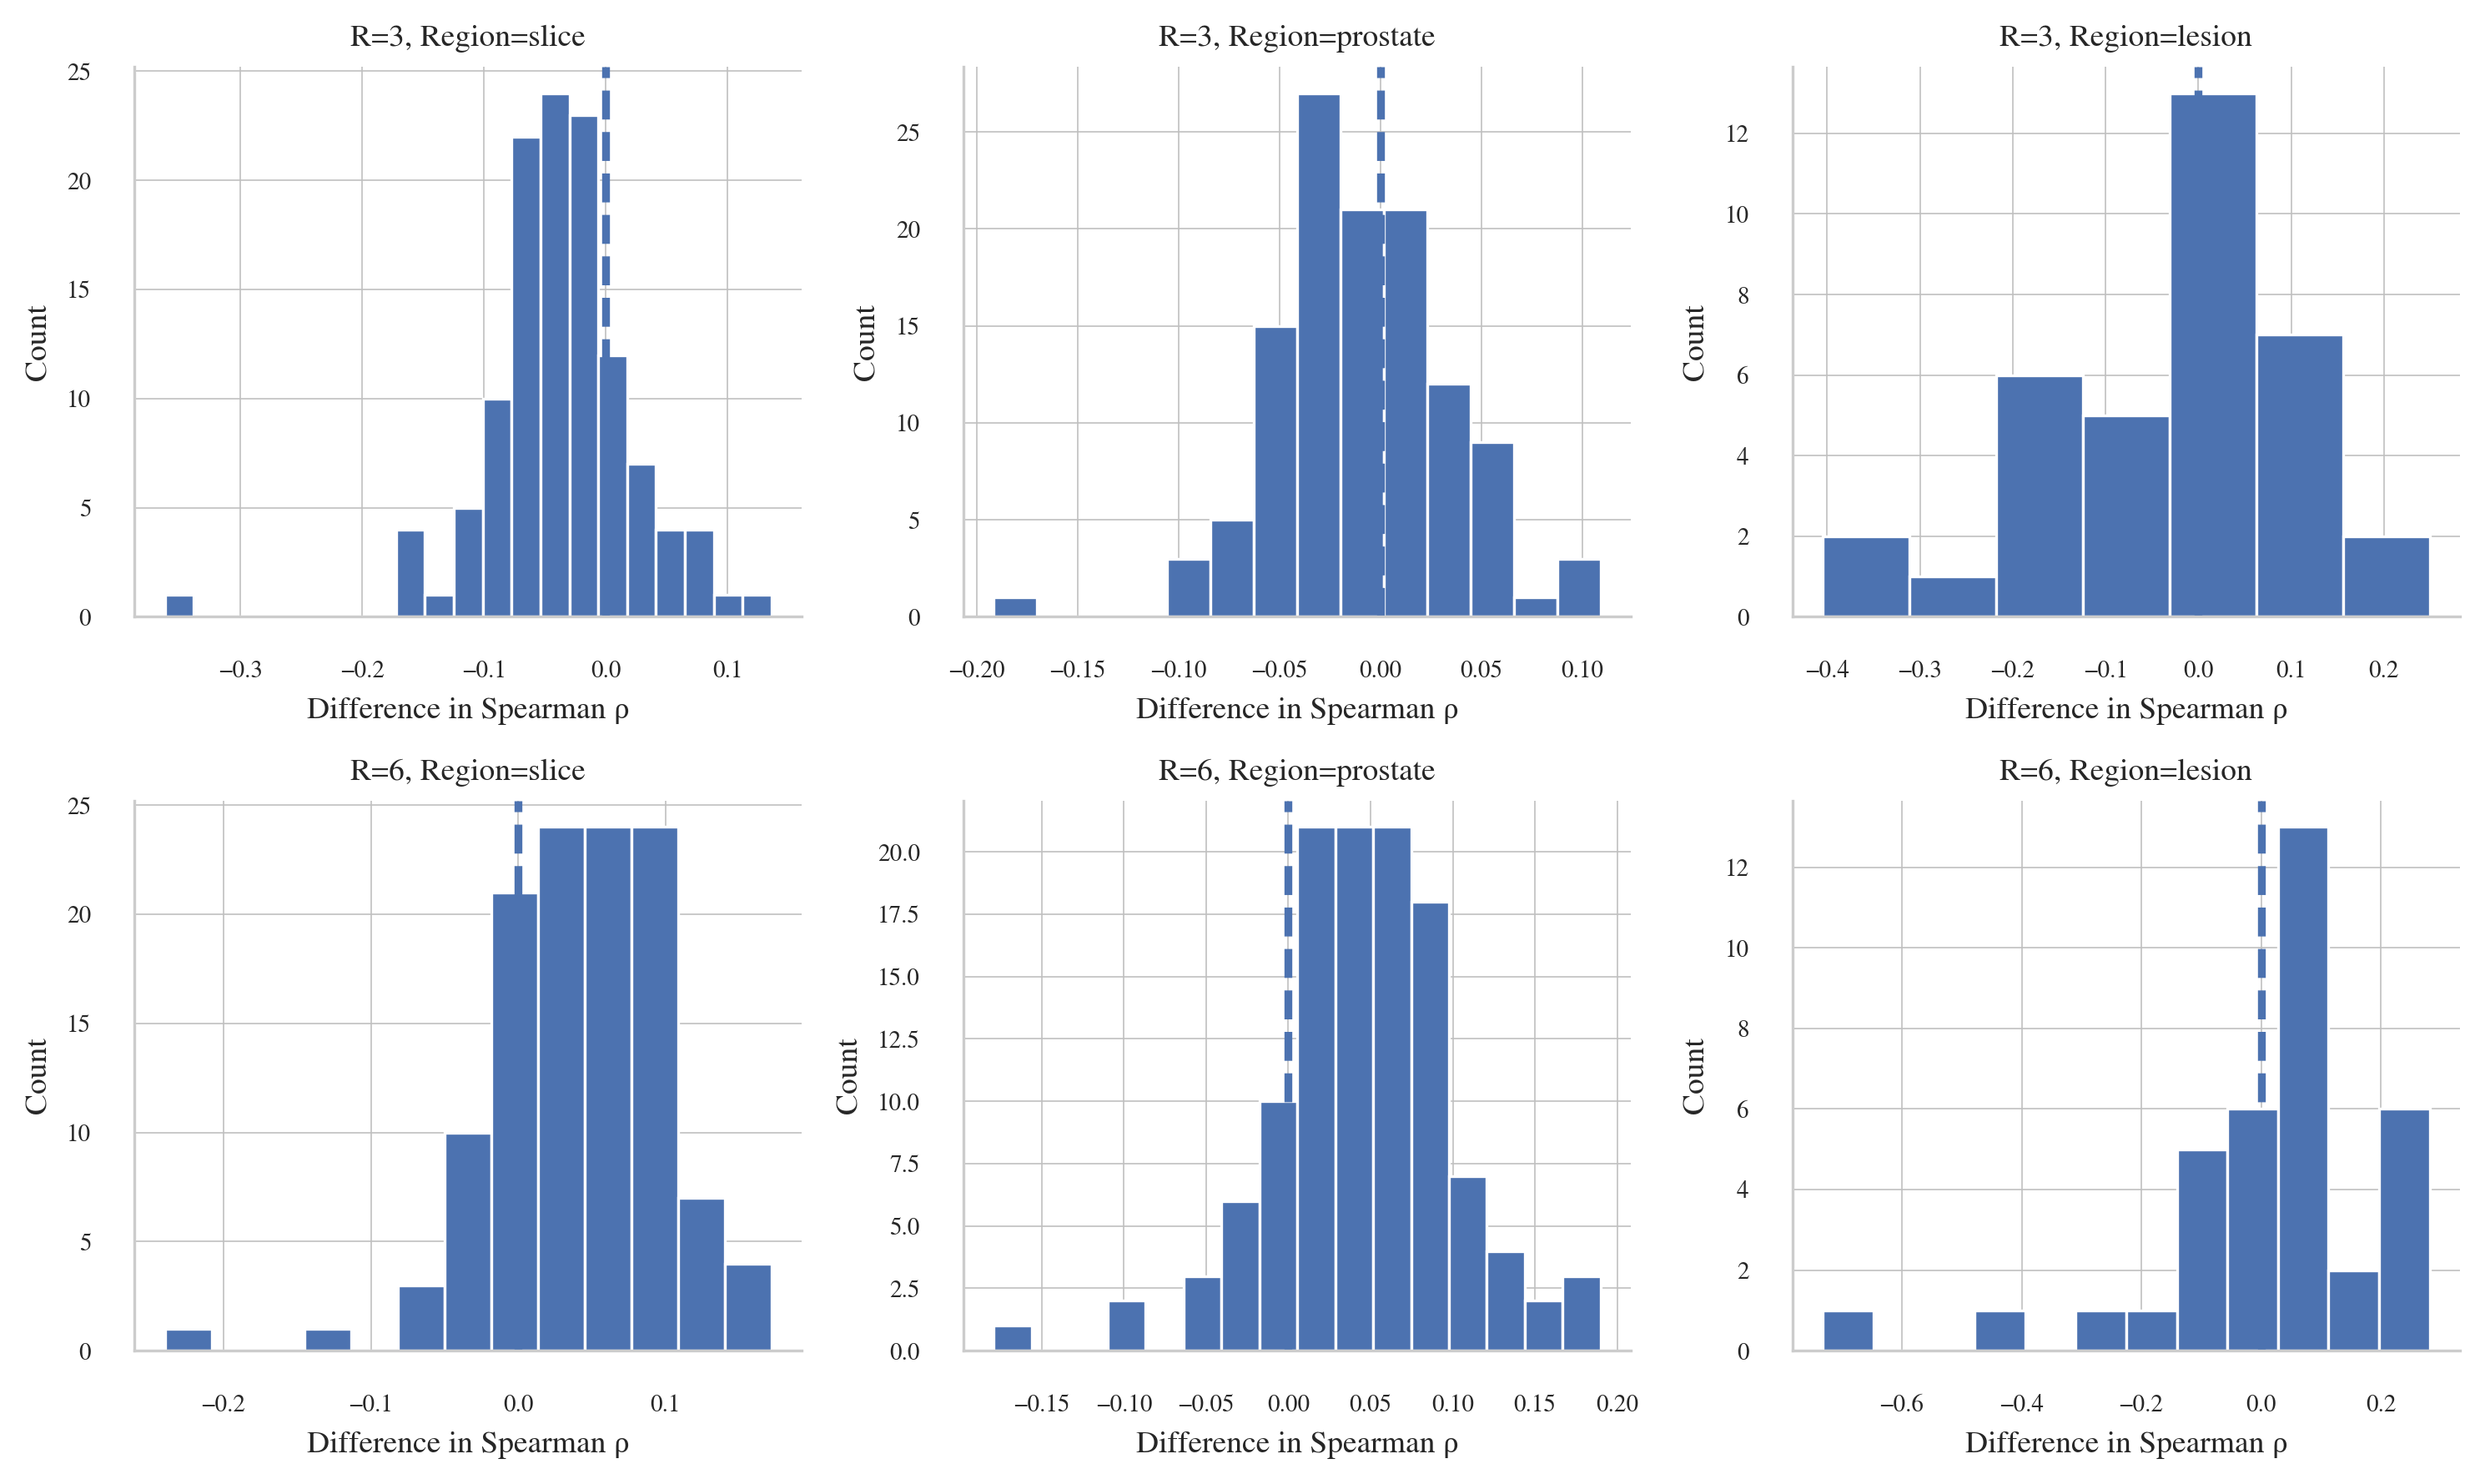

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flatten()

for idx, (R, reg) in enumerate([(R, reg) for R in ACC_LEVELS for reg in REGIONS]):
    sub = df_pat.query("R == @R and Region == @reg")
    wide = sub.pivot(index="Patient ID", columns="UQ Method", values="Correlation").dropna()
    diff = wide["GN-MC"] - wide["ET-Drop"]

    ax = axes[idx]
    ax.hist(diff, bins="auto")          # NO explicit colour
    ax.axvline(0, linestyle="--")       # reference at zero
    ax.set_title(f"R={R}, Region={reg}")
    ax.set_xlabel("Difference in Spearman ρ")
    ax.set_ylabel("Count")

    # Symmetry summary
    print(f"R={R}, Region={reg}:  mean={diff.mean():.3f}, median={np.median(diff):.3f}, n={len(diff)}")

# Adjust layout
plt.tight_layout()
plt.show()


# Figure 1 v2 - Boxplot per acceleration, region and UQ method

/tmp/ipykernel_3140719/1738837315.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([t.capitalize() for t in order_regions])
/tmp/ipykernel_3140719/1738837315.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([t.capitalize() for t in order_regions])


Figure saved → /home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/figures/spearman_violin_v1.png


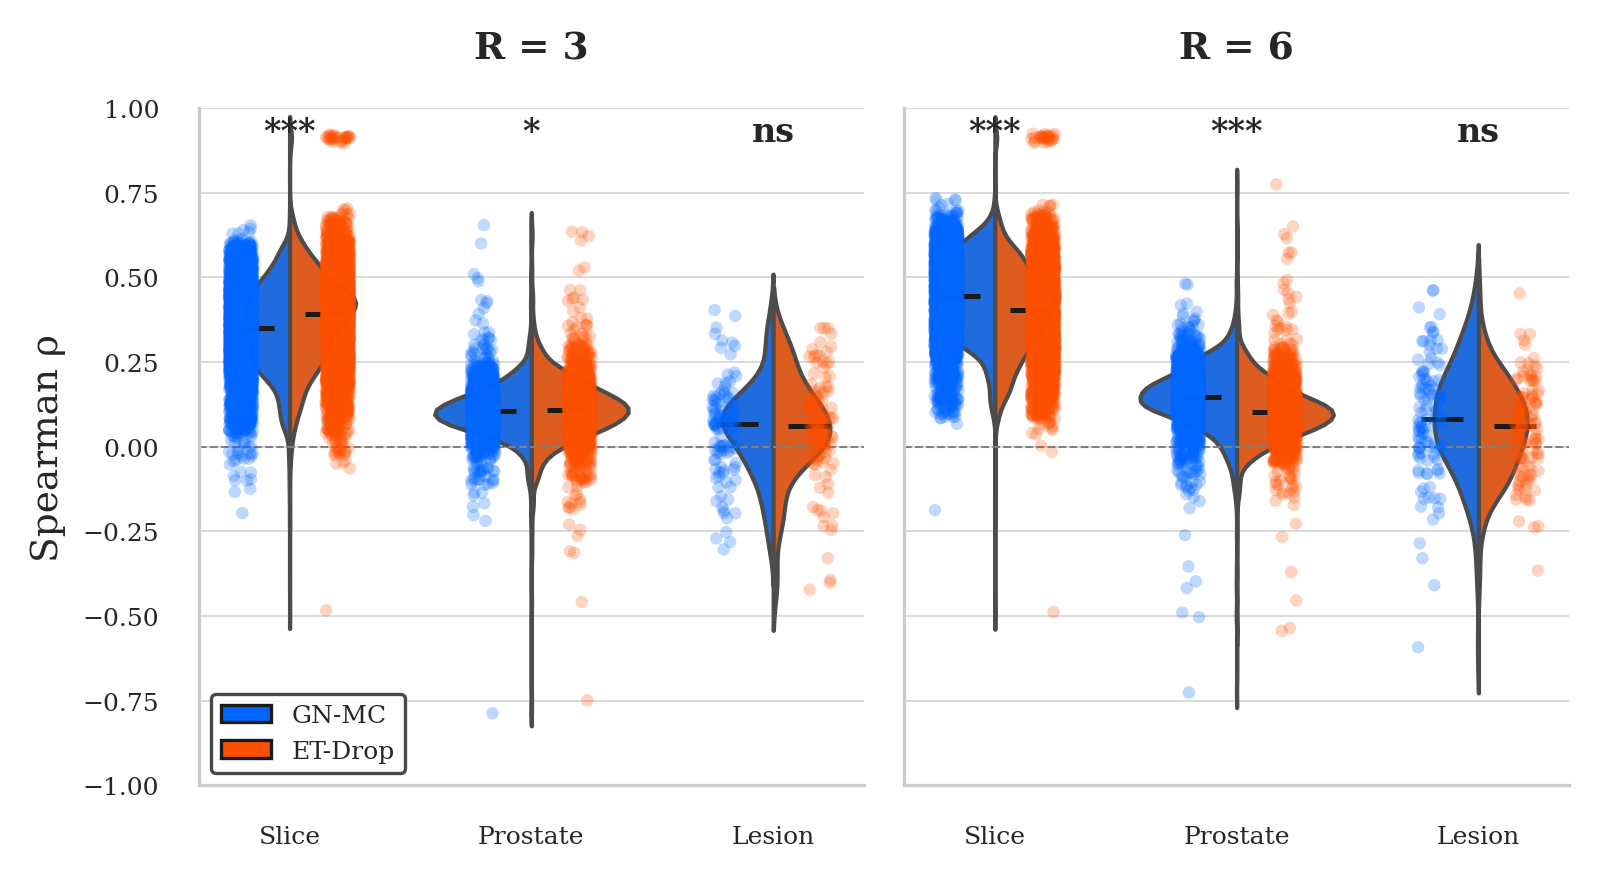

In [128]:
# ────────────────────────────────────────────────────────────────────────────
# Plot Spearman violin (slice-level dots) with Wilcoxon significance stars
# ────────────────────────────────────────────────────────────────────────────
from pathlib import Path
import matplotlib as mpl, matplotlib.pyplot as plt
import pandas as pd, seaborn as sns
from matplotlib.patches import Patch

def plot_spearman_violin_v1(df: pd.DataFrame,
                            wilcox_table: pd.DataFrame,
                            out="figures/spearman_violin_v1.png"):
    """
    Parameters
    ----------
    df : DataFrame
        Must contain columns:  Patient ID | R | UQ Method | Region | Correlation
    wilcox_table : DataFrame
        Columns required: R | region | sig
        sig should be one of '***', '**', '*', 'ns'
    out : str or Path
        Output PNG path.
    """

    # ---------------- global style ------------------------------------------
    mpl.rcParams.update({
        # text & fonts
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "font.size": 9,
        "axes.titlesize": 9,
        "axes.labelsize": 9,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "legend.fontsize": 6,
        "legend.title_fontsize": 7,
        # lines & grid
        "axes.linewidth": 0.8,
        "grid.color": "#C0C0C0",
        "grid.linewidth": 0.4,
        "patch.linewidth": 0.8,
        "lines.markersize": 3,
        # spines
        "axes.spines.top": False,
        "axes.spines.right": False,
        # dpi
        "figure.dpi": 300,
        "savefig.dpi": 600,
    })

    # ----- tidy labels ------------------------------------------------------
    df = df.copy()
    df["R_num"] = (df["R"].astype(int)
                   if pd.api.types.is_numeric_dtype(df["R"])
                   else df["R"].str.extract(r"(\d+)").astype(int))
    df = df[df["R_num"].isin([3, 6])]
    df["R_label"] = df["R_num"].map({3: "R = 3", 6: "R = 6"})
    df["UQ Method"] = df["UQ Method"].map({"gaussian": "GN-MC", "lxo": "ET-Drop"})

    order_regions = ["slice", "prostate", "lesion"]
    palette = ["#0066FF", "#FD5000"]  # blue / red

    # ---------------- figure & axes -----------------------------------------
    g = sns.catplot(
        data=df, x="Region", y="Correlation",
        hue="UQ Method", col="R_label",
        col_order=["R = 3", "R = 6"],
        kind="violin", split=True, inner=None,
        order=order_regions, palette=palette,
        height=3.0, aspect=.9, sharey=True, legend=False
    )
    g.set_titles("{col_name}", pad=12, fontweight="bold")

    # loop over facets
    for col_label, ax in zip(g.col_names, g.axes.flat):
        sub = df[df["R_label"] == col_label]

        sns.stripplot(
            data=sub, x="Region", y="Correlation",
            hue="UQ Method", dodge=True,
            marker="o", size=3, alpha=.25,
            palette=palette, order=order_regions,
            legend=False, ax=ax
        )

        # median bars
        med = sub.groupby(["Region", "UQ Method"])["Correlation"].median()
        for (reg, mth), val in med.items():
            offset = -0.15 if mth == "GN-MC" else 0.15
            ax.plot(order_regions.index(reg) + offset, val,
                    "k_", ms=10, mew=1.2)

        # significance stars -------------------------------------------------
        R_num = int(col_label.split()[-1])          # extract 3 or 6 from 'R = 3'
        for xpos, reg in enumerate(order_regions):
            try:
                star = (wilcox_table
                        .query("R == @R_num and region == @reg")
                        .sig.values[0])
            except IndexError:
                star = "ns"
            ax.text(xpos, 0.93, star,
                    ha="center", va="center",
                    fontsize=8, fontweight="bold")

        # cosmetics
        ax.set_xlabel("")
        ax.set_ylabel("Spearman ρ" if R_num == 3 else "")
        ax.set_ylim(-1, 1)
        ax.set_xticklabels([t.capitalize() for t in order_regions])
        ax.axhline(0, ls="--", lw=.5, color="grey")
        ax.grid(axis="y", linestyle="-", alpha=.7)

    # legend
    handles = [Patch(fc=palette[0], ec="k", label="GN-MC"),
               Patch(fc=palette[1], ec="k", label="ET-Drop")]
    g.axes[0][0].legend(handles=handles, loc="lower left",
                        frameon=True, edgecolor="k")

    # save
    g.fig.tight_layout()
    out = Path(out)
    out.parent.mkdir(parents=True, exist_ok=True)
    g.fig.savefig(out, dpi=600, bbox_inches="tight")
    print(f"Figure saved → {out}")

# ────────────────────────────────────────────────────────────────────────────
# Example call
# ────────────────────────────────────────────────────────────────────────────
# correlation_data  : your full slice-wise dataframe
# wilcox_table      : DataFrame with R | region | sig  (see earlier cell)

plot_spearman_violin_v1(correlation_data,
                        wilcox_table,
                        out = FIGDIR / Path("spearman_violin_v1.png"))

🧪 Next Cell: Mixed Effects Model (in Python via statsmodels)

In [4]:
import statsmodels.formula.api as smf

# Filter to valid rows
df_model = df.dropna(subset=["spearman_corr"])

# Fit a linear mixed effects model with patient as random effect
model = smf.mixedlm(
    "spearman_corr ~ uq_method * acc_factor * region",
    df_model,
    groups=df_model["pat_id"]
).fit()

# Display summary
print(model.summary())

df["region"] = df["region"].astype("category")
df["uq_method"] = df["uq_method"].astype("category")
df["pat_id"] = df["pat_id"].astype("category")

KeyError: 'pat_id'